In [1]:
import os
import importlib.util
import torch.distributed as dist
import torch
from data.builder import build_dataset
from models.detectors.zid_rcnn import ZidRCNN
from scripts import dist_util
from models.utils.data_container import collate
from functools import partial
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

/home/minhnh/python_venv/cv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def build_detector(model_cfg):
    model_cfg_ = model_cfg.copy()

    model_type = model_cfg_.pop('type') 
    assert model_type == 'ZidRCNN', f'{model_type} is not implemented yet.'
    return ZidRCNN(**model_cfg_)
    
def get_config_from_file(filename, mode):
    spec = importlib.util.spec_from_file_location(mode, filename)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)

    # Create a dictionary from module attributes
    config_dict = {key: getattr(module, key) for key in dir(module) if not key.startswith('__')}
    return config_dict

In [3]:
cfg = get_config_from_file('configs/train_detection_conf.py', 'detection')

In [4]:
dataset = build_dataset(cfg.get('data')['train'])

loading annotations into memory...
Done (t=32.18s)
creating index...
index created!
Dataset scale (before filtering):
 Images:55000
 Instances:180000


In [5]:
device = torch.device('cuda:1')

In [6]:
model = build_detector(cfg.get('model'))
model_path = '/home/minhnh/project_drive/CV/FewshotObjectDetection/VoxDet-simplified/results/ckpt/model_ep10_061000.pt'
model.load_state_dict(
    torch.load(model_path, map_location="cpu")
)
model.CLASSES = dataset.CLASSES
# # device = torch.device('cuda:4')
model.to(device)
# model.eval()
print('Loaded model')

load model from: torchvision://resnet50
LOAD Backbone ResNET50 torchvision://resnet50
Loaded model


In [10]:
data = torch.utils.data.DataLoader(dataset,
                                    batch_size=4,
                                    num_workers=2,
                                    shuffle=False,
                                    pin_memory=False,
                                    collate_fn=partial(collate, samples_per_gpu=4))

In [11]:
def batch_processing(batch):
    for k, v in batch.items():
        if k == 'img_metas':
            batch[k] = batch[k].data[0]
        if k == 'img':
            batch[k] = batch[k].data[0].to(device, non_blocking=True)
        elif k == 'gt_bboxes':
            batch[k] = batch[k].data[0]
            for i in range(len(batch[k])):
                batch[k][i] = batch[k][i].to(device, non_blocking=True)
        elif k == 'gt_labels':
            batch[k] = batch[k].data[0]
            for i in range(len(batch[k])):
                batch[k][i] = batch[k][i].to(device, non_blocking=True)
        elif k == 'gt_categories':
            batch[k] = batch[k].data[0]
            for i in range(len(batch[k])):
                batch[k][i] = batch[k][i].to(device, non_blocking=True)
        elif k == 'proposals':
            batch[k] = batch[k].data[0]
            for i in range(len(batch[k])):
                batch[k][i] = batch[k][i].to(device, non_blocking=True)
        elif k == 'support':
            batch[k] = batch[k].data[0]
            for i in range(len(batch[k])):
                batch[k][i]['rgb'] = batch[k][i]['rgb'].to(device, non_blocking=True)
                batch[k][i]['mask'] = batch[k][i]['mask'].to(device, non_blocking=True)
        elif k in ['rgb', 'mask', 'traj', 'query_pose']:
            batch[k] = batch[k].data.to(device, non_blocking=True)
    return batch

In [12]:
# results = []
# torch.multiprocessing.set_sharing_strategy('file_system')
for batch in tqdm(data):
    batch = batch_processing(batch)
    # break
    # break
    with torch.no_grad():
        output = model(**batch)
    # results.extend(output)
    break

  0%|          | 0/45000 [00:11<?, ?it/s]


In [13]:
output = torch.load('output.pt')

In [15]:
support_features = output['support_features']
roi_feats = output['roi_feats']
gt_similarity = output['gt_similarity']
overlaps = output['overlaps']


In [48]:
for g in batch['gt_categories']:
    print(len(g))

8
12
10
10


In [46]:
batch['gt_categories'][3]

tensor([4164, 3292, 5721, 6049, 9051, 7488, 9109, 8492, 6582, 7235],
       device='cuda:1')

In [44]:
i = 0
for ove in gt_similarity.T:
    # if ove.sum() > 0:
    print(f"{i}-{ove}")
    i += 1

# print(i)

0-tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], device='cuda:1')
1-tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], device='cuda:1')
2-tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], device='cuda:1')
3-tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], device='cuda:1')
4-tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.

In [43]:
for i, s in enumerate(torch.matmul(roi_feats, support_features.T)[:95]):
    print(f"{i}-{s}")

0-tensor([ 0.8237, -0.0892,  0.0016,  0.0044,  0.0270,  0.0221, -0.0496, -0.0365,
         0.0100, -0.0105,  0.1921, -0.0697, -0.0433,  0.0508,  0.0156, -0.0078,
        -0.0350,  0.0049,  0.0155, -0.0165, -0.0077,  0.1168,  0.5447, -0.0238,
        -0.1379, -0.0625,  0.0223, -0.1212, -0.0181, -0.0081,  0.0012, -0.0719,
         0.0331,  0.0198, -0.0185, -0.0449, -0.0325,  0.3978,  0.0440, -0.0323],
       device='cuda:1')
1-tensor([-0.0952,  0.9666, -0.0076, -0.0222, -0.0204, -0.0191, -0.0390, -0.1563,
         0.0339, -0.0669, -0.0778, -0.0455,  0.0828,  0.1329, -0.0135, -0.0464,
         0.0821, -0.0436, -0.0011,  0.0834, -0.0228, -0.0354, -0.0164, -0.0450,
         0.0027,  0.0042, -0.0494,  0.1447, -0.1246, -0.0611, -0.0144,  0.0366,
        -0.0234,  0.0301, -0.1340, -0.0077, -0.0464, -0.0057, -0.0456, -0.0893],
       device='cuda:1')
2-tensor([-0.0597,  0.0258,  0.9124,  0.5051, -0.0122, -0.0264,  0.0148, -0.0654,
        -0.0317, -0.0295, -0.0555, -0.0906,  0.0882,  0.0173, -0

In [34]:
gt_similarity.T

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:1')

In [14]:
outt = torch.load('outt.pt')

In [15]:
outt.keys()

dict_keys(['supp_roi_feats_contrastive', 'supp_roi_feats', 'supp_labels'])

In [16]:
for i in range(341):
    if torch.sum(outt['supp_roi_feats_contrastive'][i] - outt['supp_roi_feats'][1][0]) == 0:
        print(i)
    # print(outt['supp_roi_feats_contrastive'][i])

65


In [17]:
outt['supp_labels'].shape

torch.Size([396])

In [19]:
batch['gt_categories'][0].repeat(10 + 1, 1).transpose(1, 0).flatten().shape

torch.Size([121])

In [13]:
supcon = torch.load('supcon.pt')

In [14]:
supcon['supp_roi_feats_contrastive'] 

{'supp_roi_feats_contrastive': tensor([[1.9999e-04, 3.8226e-04, 1.8091e-03,  ..., 1.4703e-03, 2.3877e-04,
          7.9194e-05],
         [1.4865e-04, 6.7174e-04, 2.0347e-03,  ..., 1.8580e-03, 1.5468e-04,
          2.7643e-05],
         [9.4354e-05, 3.4316e-04, 1.7488e-03,  ..., 4.1604e-04, 1.3222e-04,
          4.9931e-05],
         ...,
         [1.0722e-04, 2.0040e-04, 1.1365e-04,  ..., 8.0891e-04, 8.2149e-05,
          1.3312e-06],
         [1.8864e-04, 2.9988e-04, 1.2816e-04,  ..., 1.5624e-02, 1.2188e-04,
          2.1017e-06],
         [2.2290e-04, 3.5016e-04, 1.3007e-04,  ..., 6.3596e-03, 1.1661e-04,
          4.0691e-06]], device='cuda:4'),
 'supp_labels': tensor([8129, 8129, 8129, 8129, 8129, 8129, 8129, 8129, 8129, 8129, 8129,  153,
          153,  153,  153,  153,  153,  153,  153,  153,  153,  153, 4158, 4158,
         4158, 4158, 4158, 4158, 4158, 4158, 4158, 4158, 4158, 2508, 2508, 2508,
         2508, 2508, 2508, 2508, 2508, 2508, 2508, 2508, 8351, 8351, 8351, 8351,
    

In [16]:
s = torch.matmul(supcon['supp_roi_feats_contrastive'] , supcon['supp_roi_feats_contrastive'] .T)
for x in range(s.shape[0]):
    print(s[x])


tensor([1.0000e+00, 9.9198e-01, 9.8879e-01, 9.8229e-01, 9.9264e-01, 9.5157e-01,
        9.8198e-01, 9.8716e-01, 9.9540e-01, 9.9210e-01, 9.8985e-01, 1.4425e-02,
        1.3818e-02, 1.0293e-02, 9.9723e-03, 1.4258e-02, 9.8991e-03, 1.0040e-02,
        1.1684e-02, 1.2373e-02, 1.6497e-02, 1.1177e-02, 9.5622e-03, 3.2666e-02,
        2.3499e-02, 1.4619e-02, 8.9177e-03, 1.2946e-02, 1.4313e-02, 7.2367e-03,
        1.0360e-02, 5.6771e-03, 1.2807e-02, 6.9984e-03, 1.0857e-02, 6.0328e-03,
        1.0816e-02, 8.6621e-03, 5.9573e-03, 1.0460e-02, 9.6266e-03, 1.0797e-02,
        1.0710e-02, 7.7317e-03, 3.6425e-03, 2.3612e-03, 1.4992e-03, 2.5707e-03,
        1.9947e-03, 1.9668e-03, 4.2507e-03, 1.5509e-03, 1.0569e-03, 2.4000e-03,
        1.6520e-03, 1.1067e-02, 4.9118e-03, 4.3461e-03, 7.0502e-03, 6.3174e-03,
        5.0303e-03, 2.8113e-03, 6.0839e-03, 1.6879e-02, 9.8575e-03, 4.0522e-03,
        1.1484e-02, 7.1989e-03, 3.9861e-03, 6.0644e-03, 1.0142e-02, 4.9525e-03,
        1.3988e-02, 6.2075e-03, 1.0294e-

In [43]:
num_valid = torch.sum(torch.max(gt_similarites.T, dim=1)[0] > 0)

In [44]:
num_valid

tensor(48, device='cuda:4')

In [48]:
(sim * gt_similarites.T * gt_overlaps.T)[:num_valid].sum(1) / gt_similarites.T[:num_valid].sum(1)

tensor([0.8836, 0.3325, 0.5717, 0.4402, 0.3380, 0.2874, 0.6994, 0.3945, 0.3048,
        0.3292, 0.7825, 0.7653, 0.6800, 0.6985, 0.7211, 0.7279, 0.6308, 0.6154,
        0.7055, 0.6554, 0.6501, 0.6309, 0.7110, 0.6763, 0.6058, 0.5098, 0.5476,
        0.5287, 0.6742, 0.6514, 0.4716, 0.5725, 0.6052, 0.5856, 0.5982, 0.5582,
        0.5786, 0.5474, 0.5500, 0.6444, 0.6114, 0.4967, 0.4881, 0.5462, 0.4399,
        0.5080, 0.5088, 0.5166], device='cuda:4')

In [61]:
supp_query = torch.load('supquery.pt')

In [67]:
i = 1
supp_feats = supp_query['supp_feats'][i]
roi_feats = supp_query['roi_feats'][i]
gt_similarites = supp_query['gt_similarites'][i]
gt_overlaps = supp_query['gt_overlaps'][i]

In [68]:
sim = torch.matmul(roi_feats, supp_feats.T)

In [64]:
sim

tensor([[7.6511e-01, 1.8819e-02, 4.7558e-02,  ..., 5.8413e-03, 6.3902e-02,
         6.8889e-02],
        [1.5467e-03, 6.6706e-01, 2.6397e-04,  ..., 7.4756e-01, 7.4097e-04,
         5.4742e-04],
        [1.7513e-02, 4.1643e-04, 5.8874e-01,  ..., 1.9529e-03, 6.0070e-02,
         1.1720e-01],
        ...,
        [7.4120e-02, 9.6235e-02, 3.9241e-02,  ..., 5.8239e-02, 1.6614e-01,
         2.3071e-01],
        [6.8949e-02, 9.3550e-02, 1.1591e-02,  ..., 2.7348e-02, 7.9409e-02,
         1.0350e-01],
        [2.0057e-02, 2.0772e-01, 2.2572e-02,  ..., 1.2394e-01, 1.4372e-02,
         2.2193e-02]], device='cuda:4')

In [72]:
for i in range(256):
    print(torch.where(sim[i] > 0.5))

(tensor([0], device='cuda:4'),)
(tensor([1], device='cuda:4'),)
(tensor([], device='cuda:4', dtype=torch.int64),)
(tensor([], device='cuda:4', dtype=torch.int64),)
(tensor([4], device='cuda:4'),)
(tensor([0], device='cuda:4'),)
(tensor([6], device='cuda:4'),)
(tensor([], device='cuda:4', dtype=torch.int64),)
(tensor([0], device='cuda:4'),)
(tensor([0], device='cuda:4'),)
(tensor([0], device='cuda:4'),)
(tensor([0], device='cuda:4'),)
(tensor([0], device='cuda:4'),)
(tensor([6], device='cuda:4'),)
(tensor([0], device='cuda:4'),)
(tensor([6], device='cuda:4'),)
(tensor([6], device='cuda:4'),)
(tensor([0], device='cuda:4'),)
(tensor([6], device='cuda:4'),)
(tensor([0], device='cuda:4'),)
(tensor([0], device='cuda:4'),)
(tensor([6], device='cuda:4'),)
(tensor([6], device='cuda:4'),)
(tensor([6], device='cuda:4'),)
(tensor([0], device='cuda:4'),)
(tensor([0], device='cuda:4'),)
(tensor([0], device='cuda:4'),)
(tensor([0], device='cuda:4'),)
(tensor([0], device='cuda:4'),)
(tensor([0], devic

In [56]:
for i in range(256):
    print(torch.where(sim[i] > 0.5))

(tensor([0], device='cuda:4'),)
(tensor([1, 6], device='cuda:4'),)
(tensor([2], device='cuda:4'),)
(tensor([1, 3], device='cuda:4'),)
(tensor([4], device='cuda:4'),)
(tensor([5], device='cuda:4'),)
(tensor([], device='cuda:4', dtype=torch.int64),)
(tensor([7], device='cuda:4'),)
(tensor([8], device='cuda:4'),)
(tensor([8], device='cuda:4'),)
(tensor([5], device='cuda:4'),)
(tensor([8], device='cuda:4'),)
(tensor([], device='cuda:4', dtype=torch.int64),)
(tensor([5], device='cuda:4'),)
(tensor([8], device='cuda:4'),)
(tensor([8], device='cuda:4'),)
(tensor([], device='cuda:4', dtype=torch.int64),)
(tensor([8], device='cuda:4'),)
(tensor([2], device='cuda:4'),)
(tensor([4], device='cuda:4'),)
(tensor([8], device='cuda:4'),)
(tensor([4], device='cuda:4'),)
(tensor([], device='cuda:4', dtype=torch.int64),)
(tensor([8], device='cuda:4'),)
(tensor([2], device='cuda:4'),)
(tensor([8], device='cuda:4'),)
(tensor([4], device='cuda:4'),)
(tensor([8], device='cuda:4'),)
(tensor([8], device='cuda:

In [70]:
gt_similarites.max(dim=0)[1]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 5, 5, 5, 0, 0, 6, 0, 6, 6, 0, 6, 0, 0, 6, 6, 6,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2,
        2, 2, 6, 6, 6, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:4')

In [23]:
gt_similarites

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:4')

In [12]:
out = torch.load('out.pt')

In [13]:
labels = out['assigned_gt_bboxes'][0].unsqueeze(0)

In [14]:
labels

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  8,  2,  8,  2,  1,  2,  1,  8,  2,
          2,  1,  5,  1,  5,  8,  1,  1,  2,  2,  8,  2,  1,  2,  5,  5,  2,  8,
          2,  5,  5,  5,  1,  2,  1,  1,  1,  1,  2,  1,  2,  8,  5,  8,  5,  1,
          5,  5,  2,  2,  1,  2,  1,  5,  5,  5,  5,  5,  2,  8,  5,  5,  5,  7,
          0,  4,  2,  0,  7,  4,  0,  7,  0,  7,  1,  1,  7,  2,  8,  4,  4,  8,
          4,  1,  4,  0,  6,  7,  0,  6,  0,  7,  4,  7,  7,  5,  4,  8,  4,  8,
          5,  4,  6,  4,  0,  2,  8,  8,  1,  1,  5,  8,  6,  5,  3,  3,  4,  4,
          4,  4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1,

In [15]:
label_mask = torch.eq(labels.T, labels).float()

In [16]:
for i in label_mask:
    print(i)

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [12]:
torch.max(out['pred_similarities'][0], dim=1)

torch.return_types.max(
values=tensor([0.0096, 0.0074, 0.0182, 0.0210, 0.0106, 0.0194, 0.0128, 0.0117, 0.0117,
        0.0193, 0.0183], device='cuda:0'),
indices=tensor([195, 224, 224, 224, 195, 224, 224, 195, 195, 224, 224],
       device='cuda:0'))

In [10]:
batch['gt_categories']

[tensor([   9, 9344, 7105, 3645, 8916, 6125, 6772, 5478, 6001, 1714, 3073],
        device='cuda:4'),
 tensor([ 918,  628, 4510, 6285,  645,  223, 9327, 8787, 4092, 4570, 4267, 3694],
        device='cuda:4'),
 tensor([7365, 9461, 2350, 3614, 2392, 8593, 7373, 1434, 5296], device='cuda:4'),
 tensor([2866,  650, 6157, 3897, 9232, 9512, 8164], device='cuda:4')]

In [10]:
sample = torch.load('sample.pt')

In [25]:
sample['gt_bboxes'][0].shape

torch.Size([10, 40, 3, 224, 224])

In [11]:
bbox_feats = sample['bbox_feats']
support = sample['support']
rois = sample['rois']
gt_bboxes = sample['gt_bboxes']

In [15]:
bbox_feats.shape

torch.Size([1024, 256, 7, 7])

In [14]:
support[0].shape

torch.Size([10, 40, 3, 224, 224])

In [12]:
rois.shape

torch.Size([1024, 5])

In [14]:
gt_bboxes[0].shape

torch.Size([13, 4])

In [18]:
rois[:, 1:].shape

torch.Size([1024, 4])

In [20]:
rpn = rois[:, 1:].reshape(4, -1, 4)

In [22]:
from models.utils.rpn_utils import BboxOverlaps2D

In [23]:
iou_calculator = BboxOverlaps2D()

In [25]:
overlaps = iou_calculator(gt_bboxes[0], rpn[0])

In [28]:
overlaps

tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0380, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000,  ..., 0.0182, 0.0184, 0.0000],
        [0.0000, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.1091, 0.0000, 0.0000,  ..., 0.0683, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0915, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0217, 0.0000, 0.0000]],
       device='cuda:4')

In [29]:
max_overlaps, argmax_overlaps = overlaps.max(dim=0)

In [32]:
max_overlaps

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.5023, 0.5172, 0.8719, 0.6214, 0.8525,
        0.5097, 0.5238, 0.5245, 0.8054, 0.5912, 0.7079, 0.5418, 0.7108, 0.8556,
        0.8555, 0.5086, 0.7835, 0.5603, 0.7852, 0.7697, 0.6195, 0.9057, 0.9126,
        0.8947, 0.9083, 0.8990, 0.6938, 0.5439, 0.8770, 0.8503, 0.8081, 0.6345,
        0.8864, 0.8170, 0.7404, 0.8053, 0.6123, 0.5893, 0.6017, 0.6167, 0.5235,
        0.7438, 0.5879, 0.5490, 0.5251, 0.5327, 0.5624, 0.5342, 0.7566, 0.7819,
        0.8913, 0.1161, 0.1129, 0.0552, 0.0469, 0.0477, 0.0000, 0.0000, 0.0266,
        0.0000, 0.0000, 0.0000, 0.0485, 0.0522, 0.0000, 0.0000, 0.0000, 0.0150,
        0.0000, 0.0000, 0.0000, 0.0120, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0196, 0.0000, 0.0000, 0.0000, 0.0000, 0.4066,
        0.2067, 0.0318, 0.0724, 0.0000, 0.2914, 0.0000, 0.0000, 0.0000, 0.0865,
        0.1778, 0.0000, 0.0056, 0.0000, 

In [31]:
argmax_overlaps

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 12, 12,  8, 12, 10,
        12, 12,  2,  1,  9,  2,  9,  0, 10, 10,  2,  8,  9,  1, 10, 10,  7,  3,
         7,  6, 11, 11,  1,  6,  3,  3,  6,  3,  6,  9,  7,  0,  9,  5,  3,  9,
         6,  7,  4,  4,  4,  3,  3,  3, 11, 11,  9,  9,  5,  5,  5,  0,  0,  7,
         0,  0,  0,  9,  5,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0,
         0,  0,  0,  4,  0,  0,  0,  0, 12,  2,  3,  7,  0, 12,  0,  0,  0,  9,
         2,  0, 11,  0, 12,  0,  0,  0,  0,  0,  7,  6,  0,  0,  2,  0,  0,  0,
         0,  0, 10,  7, 10,  0,  0,  0,  0,  4,  0,  0,  1,  4,  3,  0,  8,  6,
         0,  0,  2,  4,  9,  5,  7,  0,  0,  8,  6,  0,  0,  0,  4,  6,  0,  1,
         4,  4,  0,  9,  1,  1,  0,  0,  0,  0,  1,  0,  7,  0,  1,  0,  0,  0,
         1,  0,  0,  0,  0,  6,  0,  0,  0, 12,  8,  0,  0,  8,  0,  0,  0,  8,
         0,  0,  1,  0,  0,  0,  1,  4,  9,  0,  0,  7,  0,  6,  8,  0,  7,  0,
         0,  7,  6,  1,  0,  4,  4,  5, 

In [33]:
num_gts, num_bboxes = overlaps.shape[0], overlaps.shape[1]
assigned_gt_inds = overlaps.new_full((num_bboxes, ),
                                             -1,
                                             dtype=torch.long)

In [34]:
pos_inds = max_overlaps >= 0.7
assigned_gt_inds[pos_inds] = argmax_overlaps[pos_inds]

In [35]:
assigned_gt_inds

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, -1, -1,  8, -1, 10,
        -1, -1, -1,  1, -1,  2, -1,  0, 10, 10, -1,  8, -1,  1, 10, -1,  7,  3,
         7,  6, 11, -1, -1,  6,  3,  3, -1,  3,  6,  9,  7, -1, -1, -1, -1, -1,
         6, -1, -1, -1, -1, -1, -1,  3, 11, 11, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, 

In [37]:
similarities = torch.zeros_like(overlaps)

In [38]:
for i, gt_idx in enumerate(assigned_gt_inds):
    if gt_idx >= 0:
        similarities[gt_idx, i] = 1.0

In [39]:
similarities

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:4')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


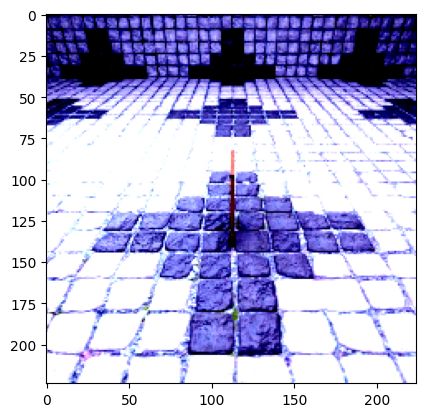

In [28]:
plt.imshow(batch['support'][0][2][0].cpu().permute(1,2,0))

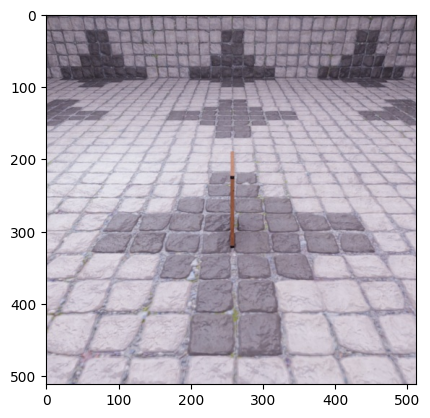

In [29]:
plt.imshow(read_image('/home/minhnh/project_drive/CV/FewshotObjectDetection/data/OWID/P1/6128/rgb/000000.jpg'))


In [24]:
plt.imshow(read_image('/home/minhnh/project_drive/CV/FewshotObjectDetection/data/OWID//P2/images/041260.jpg'))

FileNotFoundError: [Errno 2] No such file or directory: '/home/minhnh/project_drive/CV/FewshotObjectDetection/data/OWID//P2/images/6397.jpg'

In [15]:
batch['gt_categories']

[tensor([3912, 1327, 8210, 9414, 8997, 5926,  971, 9340, 7932, 6239],
        device='cuda:4'),
 tensor([6227,  950, 3727, 3949, 5106, 2347, 7002, 1883,  811], device='cuda:4'),
 tensor([4406, 3464,  942, 4211, 8989, 1598, 4520, 8057, 3043, 3510],
        device='cuda:4'),
 tensor([1393, 1088,  234, 3727, 1697, 5748, 1297, 4944], device='cuda:4')]

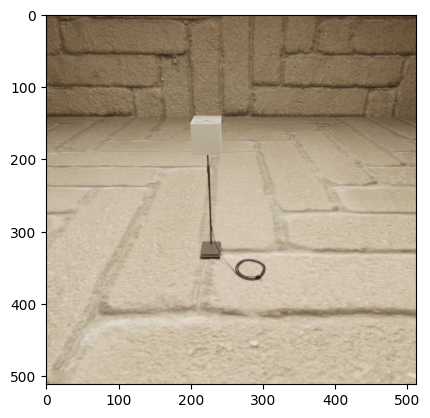

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


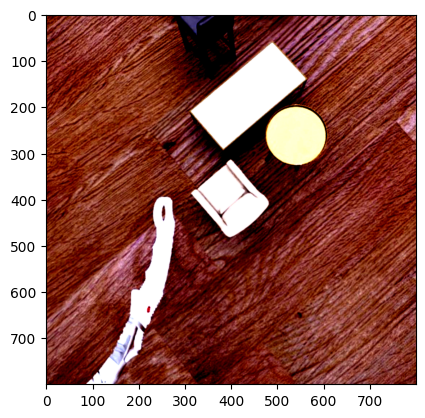

In [39]:
plt.imshow(batch['img'][0].cpu().permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


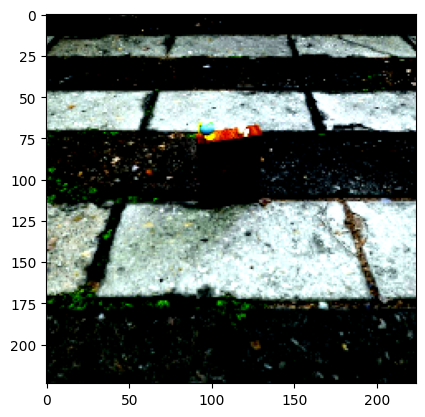

In [24]:
plt.imshow(batch['rgb'][3][10].cpu().permute(1,2,0))

In [89]:
dataset.coco.getAnnIds(76471)

[490413, 490414, 490415, 490416, 490417, 490418, 490419]

In [14]:
dataset.pipeline.transforms

[LoadImageFromFile(to_float32=False, color_type='color', file_client_args={'backend': 'disk'}),
 LoadAnnotations(with_bbox=True, with_label=True, with_mask=False, with_seg=False, poly2mask=True, poly2mask={'backend': 'disk'}),
 Resize(img_scale=[(1333, 800)], multiscale_mode=range, ratio_range=None, keep_ratio=True, bbox_clip_border=True),
 RandomFlip(flip_ratio=0.5),
 Normalize(mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375], to_rgb=True),
 Pad(size=None, size_divisor=32, pad_val=0),
 DefaultFormatBundle,
 Collect(keys=['img', 'gt_bboxes', 'gt_labels'], meta_keys=('filename', 'ori_filename', 'ori_shape', 'img_shape', 'pad_shape', 'scale_factor', 'flip', 'flip_direction', 'img_norm_cfg'))]

In [28]:
def trans(data, idx):
    i = 0
    for t in dataset.pipeline.transforms[:idx]:
        if hasattr(t, 'transforms'):
            t.transforms.transforms = t.transforms.transforms[:idx]
            # for s in t.transforms.transforms[:idx]:
            data = t(data)
        else:
            data = t(data)
            
    return data

In [16]:
f = trans(results, 7)

In [17]:
f

{'img_info': {'id': 35869,
  'file_name': 'images/036323.jpg',
  'width': 512,
  'height': 512,
  'date_captured': '2023-03-07 23:43:13.262161',
  'license': 1,
  'coco_url': '',
  'flickr_url': '',
  'filename': 'images/036323.jpg',
  'ann_id': 3,
  'obj_id': 6182},
 'ann_info': {'bboxes': array([[ 66., 261., 215., 389.],
         [271., 162., 385., 379.],
         [  0., 340., 261., 478.],
         [197., 203., 296., 333.],
         [163., 188., 235., 274.],
         [ 52., 250., 119., 309.],
         [194., 196., 313., 323.]], dtype=float32),
  'labels': array([0, 1, 1, 1, 1, 1, 1]),
  'categories': array([4288, 4064, 3206, 6875, 4074, 1201, 9464]),
  'cam_R_m2c': [array([[ 0.04893114, -1.06872678, -0.81314388],
          [ 1.32626742,  0.16612613, -0.13853344],
          [ 0.21070153, -0.79749568,  1.06083924]])],
  'bboxes_ignore': array([], shape=(0, 4), dtype=float32),
  'masks': [{'counts': [34103,
     2,
     510,
     4,
     507,
     7,
     505,
     9,
     503,
     10,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


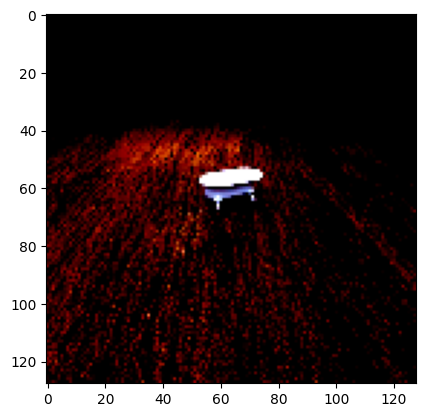

In [89]:
plt.imshow((batch['rgb'][3][0].cpu()).permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


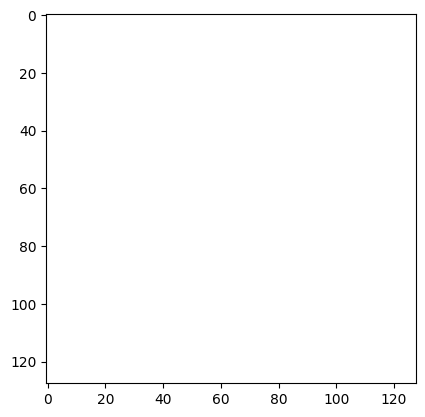

In [109]:
s = np.float64(batch['rgb'][3][0].cpu()).transpose(1,2,0)
plt.imshow(s * std + mean)

In [114]:
s = np.load('/home/minhnh/project_drive/CV/FewshotObjectDetection/data/OWID/P1/0/info.npz')['rgb']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


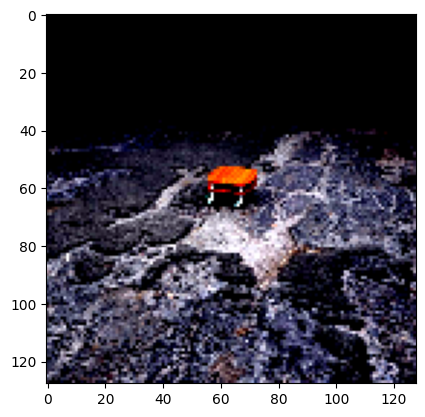

In [129]:
plt.imshow(s[2].transpose(1,2,0))

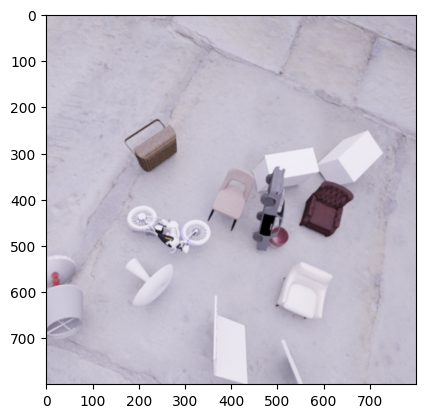

In [51]:
plt.imshow(np.array([f['img'][:, :, 2], f['img'][:, :, 1], f['img'][:, :, 0]]).transpose(1,2,0))

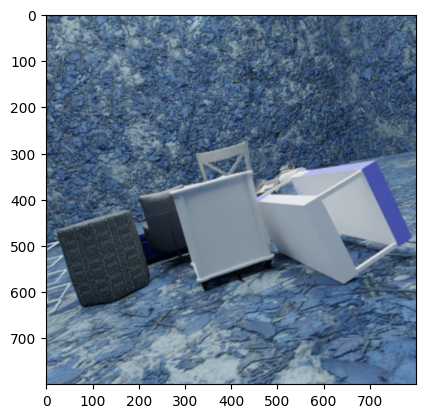

In [29]:
f = trans(results, 4)
plt.imshow(np.array([f['img'][:, :, 0], f['img'][:, :, 1], f['img'][:, :, 2]]).transpose(1,2,0))

In [30]:
results.keys()

dict_keys(['img_info', 'ann_info', 'img_prefix', 'seg_prefix', 'proposal_file', 'bbox_fields', 'mask_fields', 'seg_fields', 'filename', 'ori_filename', 'img', 'img_shape', 'ori_shape', 'img_fields', 'gt_bboxes', 'gt_bboxes_ignore', 'gt_labels', 'gt_categories', 'scale', 'scale_idx', 'pad_shape', 'scale_factor', 'keep_ratio', 'flip', 'flip_direction'])

In [26]:
img_info = data_info[1]
ann_info = dataset.get_ann_info(1)
results = dict(img_info=img_info, ann_info=ann_info)
dataset.pre_pipeline(results)
# f = dataset.pipeline(results)

In [13]:
results

{'img_info': {'id': 35869,
  'file_name': 'images/036323.jpg',
  'width': 512,
  'height': 512,
  'date_captured': '2023-03-07 23:43:13.262161',
  'license': 1,
  'coco_url': '',
  'flickr_url': '',
  'filename': 'images/036323.jpg',
  'ann_id': 3,
  'obj_id': 6182},
 'ann_info': {'bboxes': array([[ 66., 261., 215., 389.],
         [271., 162., 385., 379.],
         [  0., 340., 261., 478.],
         [197., 203., 296., 333.],
         [163., 188., 235., 274.],
         [ 52., 250., 119., 309.],
         [194., 196., 313., 323.]], dtype=float32),
  'labels': array([0, 1, 1, 1, 1, 1, 1]),
  'categories': array([4288, 4064, 3206, 6875, 4074, 1201, 9464]),
  'cam_R_m2c': [array([[ 0.04893114, -1.06872678, -0.81314388],
          [ 1.32626742,  0.16612613, -0.13853344],
          [ 0.21070153, -0.79749568,  1.06083924]])],
  'bboxes_ignore': array([], shape=(0, 4), dtype=float32),
  'masks': [{'counts': [34103,
     2,
     510,
     4,
     507,
     7,
     505,
     9,
     503,
     10,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


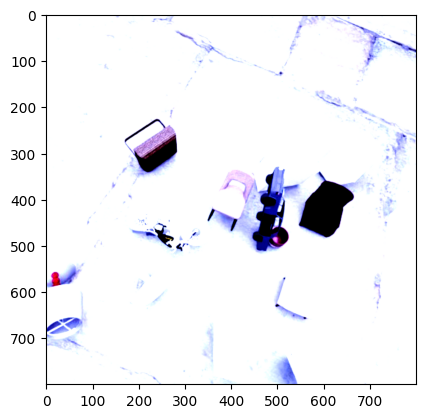

In [40]:
plt.imshow(f['img'].data.permute(1,2,0))

In [158]:
s = np.load('/home/minhnh/project_drive/CV/FewshotObjectDetection/data/OWID/P1/9676/info.npz')

In [159]:
s.keys()

KeysView(NpzFile '/home/minhnh/project_drive/CV/FewshotObjectDetection/data/OWID/P1/9676/info.npz' with keys: rgb, mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


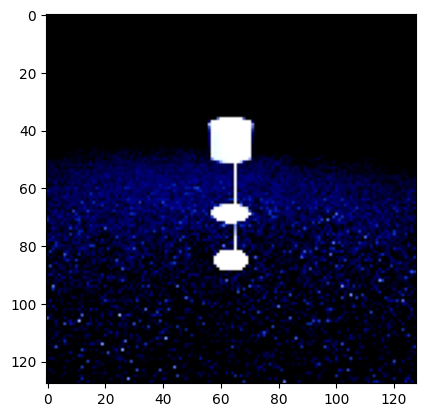

In [104]:
plt.imshow(s['rgb'][32].transpose(1,2,0))

In [25]:
ann_file = '/home/minhnh/project_drive/CV/FewshotObjectDetection/data/OWID/P2/train_annotations.json'
data_info = dataset.load_annotations(ann_file)

loading annotations into memory...
Done (t=33.10s)
creating index...
index created!
Dataset scale (before filtering):
 Images:55000
 Instances:180000


In [6]:
data_info[1]

{'id': 10666,
 'file_name': 'images/010796.jpg',
 'width': 512,
 'height': 512,
 'date_captured': '2023-03-03 08:15:11.584046',
 'license': 1,
 'coco_url': '',
 'flickr_url': '',
 'filename': 'images/010796.jpg',
 'ann_id': 5,
 'obj_id': 6845}

In [7]:
img_id = dataset.data_infos[1]['id']
ann_ids = dataset.coco.get_ann_ids(img_ids=[img_id])
ann_info = dataset.coco.load_anns(ann_ids)

In [10]:
ann_info

[{'id': 87437,
  'image_id': 13552,
  'category_id': 3910,
  'iscrowd': 0,
  'area': 4136,
  'bbox': [90, 152, 66, 106],
  'segmentation': {'counts': [46319,
    2,
    507,
    7,
    502,
    10,
    499,
    13,
    496,
    16,
    492,
    21,
    475,
    4,
    9,
    24,
    471,
    8,
    6,
    27,
    467,
    11,
    4,
    31,
    462,
    11,
    3,
    36,
    459,
    10,
    2,
    41,
    455,
    10,
    5,
    42,
    452,
    9,
    2,
    1,
    4,
    45,
    448,
    9,
    4,
    51,
    445,
    8,
    3,
    2,
    2,
    52,
    442,
    8,
    6,
    57,
    438,
    8,
    4,
    2,
    1,
    59,
    435,
    8,
    2,
    1,
    3,
    63,
    432,
    8,
    4,
    68,
    429,
    8,
    2,
    1,
    3,
    70,
    426,
    7,
    4,
    75,
    424,
    7,
    5,
    76,
    423,
    5,
    5,
    80,
    423,
    2,
    3,
    84,
    424,
    88,
    422,
    90,
    419,
    94,
    416,
    96,
    414,
    98,
    414,
    99,
    414,
    98,


In [19]:
categories = [(ann['bbox'], ann['category_id']) for ann in ann_info]

In [23]:
for box, category_id in categories:
    if box == [135, 165, 83, 116]:
        print(box, category_id)

[135, 165, 83, 116] 4987


In [23]:
def read_image(filepath):
    # Open the image file
    img = Image.open(filepath)
    # Convert the image to a Numpy array
    img_array = np.array(img)
    # Display the array
    return img_array

In [72]:
img.max()

2.64

In [64]:
img = read_image('/home/minhnh/project_drive/CV/FewshotObjectDetection/data/OWID//P2/images/053303.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


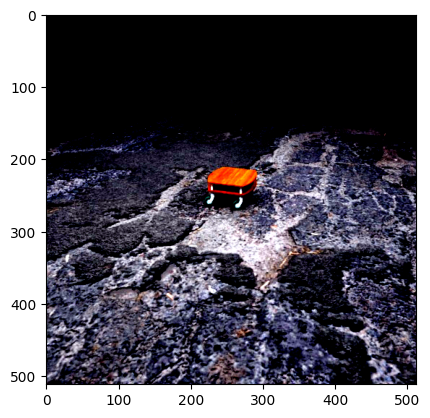

In [130]:
import cv2
img = read_image('/home/minhnh/project_drive/CV/FewshotObjectDetection/data/OWID/P1/0/rgb/000002.jpg')
img = np.float64(img)
mean = np.array([123.675, 116.28, 103.53])
std = np.array([58.39, 57.12, 57.375])
mean = np.float64(mean.reshape(1, -1))
stdinv = 1 / np.float64(std.reshape(1, -1))
cv2.subtract(img, mean, img)  # inplace
cv2.multiply(img, stdinv, img)  # inplace
plt.imshow(img)

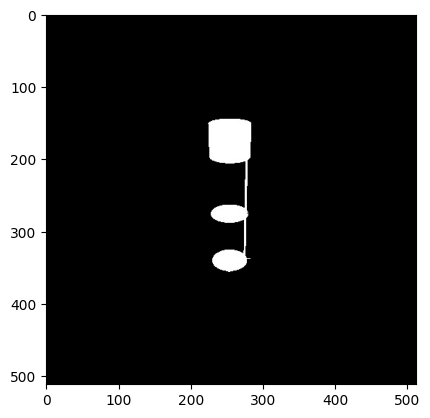

In [90]:
img = read_image('/home/minhnh/project_drive/CV/FewshotObjectDetection/data/OWID/P1/9676/mask/000000.jpg')
plt.imshow(img)

In [7]:
def test_batch_processing(batch):
    batch['obj_id'] = batch['id'][0]
    batch.pop('id')
    for k, v in batch.items():
        if k == 'img_metas':
            batch[k] = batch[k][0].data
        if k == 'img':
            batch[k] = [batch[k][0].data[0].to(device, non_blocking=True)]
        
        elif k in ['rgb', 'mask', 'traj']:
            batch[k] = batch[k].data.to(device, non_blocking=True)
    return batch

In [8]:
results = []
torch.multiprocessing.set_sharing_strategy('file_system')
for batch in tqdm(data):
    batch = test_batch_processing(batch)
    with torch.no_grad():
        output = model(**batch, return_loss=False, rescale=True)
    results.extend(output)
    # break

  0%|          | 0/9109 [00:00<?, ?it/s]/home/minhnh/python_venv/cv/lib/python3.9/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/minhnh/python_venv/cv/lib/python3.9/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
  1%|▏         | 128/9109 [00:13<15:44,  9.50it/s]


KeyboardInterrupt: 

In [9]:
a = torch.load('bbox.pt')

In [145]:
with torch.no_grad():
    feat = model(batch['rgb'].flatten(0,1))

AssertionError: Input height (128) doesn't match model (224).

In [5]:
from timm.models.vision_transformer import VisionTransformer, _cfg
import torch.nn as nn

/home/minhnh/python_venv/cv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
model = VisionTransformer(
        patch_size=16, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6))
model.default_cfg = _cfg()
# if pretrained:
checkpoint = torch.load('/home/minhnh/project_drive/CV/FewshotObjectDetection/VoxDet-simplified/deit_small_patch16_224-cd65a155.pth')
model.load_state_dict(checkpoint["model"],strict=False)
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [17]:
with torch.no_grad():
    feat = model(batch['rgb'].flatten(0,1))

In [18]:
feat.shape

torch.Size([160, 1000])

In [153]:
a = np.load('/home/minhnh/project_drive/CV/FewshotObjectDetection/data/RoboTools/test_video/obj_000002/info.npz')

In [154]:
a['rgb'].shape

(100, 3, 128, 128)

In [ ]:
dataset.format_results(results, 'results')

In [16]:
dataset.evaluate(results, jsonfile_prefix='results')

Loading and preparing results...
DONE (t=3.59s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.82s).
Accumulating evaluation results...
DONE (t=0.23s).
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.186
Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets=  1 ] = 0.237
Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets=  1 ] = 0.204
Average Recall     (AR) @[ IoU=0.95      | area=   all | maxDets=  1 ] = 0.049
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=  1 ] = 0.000
Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=  1 ] = 0.062
Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=  1 ] = 0.208

+----------+-------+----------+-------+----------+-------+----------+-------+
| category | mAR@1 | category | mAR@1 | category | mAR@1 | category | mAR@1 |
+----------+-------+----------+-------+----------+-------+----------+-------+


OrderedDict()

In [12]:
rpn_score.shape

NameError: name 'rpn_score' is not defined

In [20]:
import json
with open('results_bbox.json', 'r') as f:
    d = json.load(f)

In [22]:
results[0]

[array([[2.61270213e+00, 3.44715834e+00, 1.11472565e+02, 2.37138062e+02,
         6.20508015e-01],
        [1.44633167e+03, 1.66792740e+02, 1.54369690e+03, 3.90560760e+02,
         4.02943194e-01],
        [1.44692871e+03, 1.93840561e+02, 1.56173767e+03, 3.67743164e+02,
         3.87540609e-01],
        [1.44457153e+03, 1.84359024e+02, 1.52236938e+03, 3.87534485e+02,
         3.18059772e-01],
        [9.50674622e+02, 3.07155701e+02, 1.00872827e+03, 4.32867584e+02,
         2.26538673e-01],
        [8.70195198e+00, 8.77730727e-01, 3.51192261e+02, 3.09769897e+02,
         1.95920125e-01],
        [4.56626844e+00, 0.00000000e+00, 4.60439423e+02, 6.63886108e+02,
         1.57428801e-01],
        [6.67571045e+02, 6.38303528e+02, 9.37478699e+02, 9.29668762e+02,
         1.48093119e-01],
        [6.09473896e+00, 5.91534710e+00, 4.14537018e+02, 5.11056549e+02,
         1.45650685e-01],
        [5.94915222e+02, 2.09968155e+02, 1.16700610e+03, 9.94778503e+02,
         1.16915017e-01],
        [6

In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [114]:
s = []
for da in d:
    if da['category_id'] == 9:
        s.append(da)

In [122]:
dataset.coco

In [130]:
s[0]

{'image_id': 966,
 'bbox': [561.4679565429688,
  421.6319580078125,
  219.3992919921875,
  153.840576171875],
 'score': 0.4402926564216614,
 'category_id': 9}

In [117]:
idx = 966
i = 0
for batch in tqdm(data):
    if i == idx:
        batch = test_batch_processing(batch)
        output = results[i]
        break
    i += 1

 11%|█         | 966/9109 [01:31<12:52, 10.54it/s]


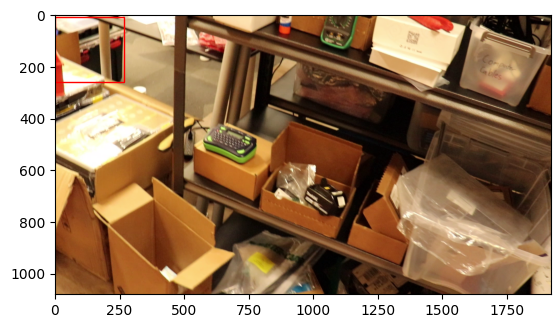

In [121]:
filepath = batch['img_metas'][0][0]['filename']

im = Image.open(filepath)

# Create figure and axes
fig, ax = plt.subplots()
x1, y1, x2, y2, score = output[0][3]
# Display the image
ax.imshow(im)

# Create a Rectangle patch
rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [57]:
def forward_test_det(img, img_metas, 
                 rgb=None,
                 mask=None,
                 traj=None,**kwargs):
    """
    Args:
        imgs (List[Tensor]): the outer list indicates test-time
            augmentations and inner Tensor should have a shape NxCxHxW,
            which contains all images in the batch.
        img_metas (List[List[dict]]): the outer list indicates test-time
            augs (multiscale, flip, etc.) and the inner list indicates
            images in a batch.
    """
    for var, name in [(img, 'imgs'), (img_metas, 'img_metas')]:
        if not isinstance(var, list):
            raise TypeError(f'{name} must be a list, but got {type(var)}')
    num_augs = len(img)
    if num_augs != len(img_metas):
        raise ValueError(f'num of augmentations ({len(img)}) '
                         f'!= num of image meta ({len(img_metas)})')
    # NOTE the batched image size information may be useful, e.g.
    # in DETR, this is needed for the construction of masks, which is
    # then used for the transformer_head.
    for w, img_meta in zip(img, img_metas):
        img_meta[0]['batch_input_shape'] = tuple(w.size()[-2:])
    if num_augs == 1:
        # proposals (List[List[Tensor]]): the outer list indicates
        # test-time augs (multiscale, flip, etc.) and the inner list
        # indicates images in a batch.
        # The Tensor should have a shape Px4, where P is the number of
        # proposals.
        if 'proposals' in kwargs:
            kwargs['proposals'] = kwargs['proposals'][0]
        return simple_test(img[0], img_metas[0], rgb, mask, traj, **kwargs)
    else:
        assert imgs[0].size(0) == 1, 'aug test does not support ' \
                                     'inference with batch size ' \
                                     f'{imgs[0].size(0)}'
        # TODO: support test augmentation for predefined proposals
        assert 'proposals' not in kwargs
        return model.aug_test(img, img_metas, rgb, mask, traj, **kwargs)

# def init(model, p1_path=None, pkl_path='/ws/ROS/src/zid3d_ros/Zid3D/support_feat.pkl'):
#     """Generate P1 support"""
#     if not p1_path:
#         with open(pkl_path, 'rb') as f:
#             model.p1_2D = pkl.load(f)
#         return

#     p1_data = np.load(os.path.join(p1_path, 'info.npz'))
#     rgb = torch.from_numpy(p1_data['rgb'].astype(np.float32)).unsqueeze(0).cuda()
#     mask = torch.from_numpy(p1_data['mask'].astype(np.float32)).unsqueeze(0).cuda()
#     # depth = torch.from_numpy(p1_data['depth'].astype(np.float32)).cuda()

#     ref_rgb = model.extract_feat(rgb.flatten(0, 1))
#     mask = mask[:,:,0].flatten(0,1)
#     mask[mask>220] = 255
#     mask[mask<210] = 0
#     boxes_p1 = model.masks_to_boxes(mask)
#     p1_2D = {'feat': ref_rgb, 'box': boxes_p1, 'mask': mask, 'traj': traj}
#     with open(pkl_path, 'wb') as f:
#         pkl.dump(model.p1_2D, f)

def simple_test(img, img_metas,                      
                 rgb=None,
                 mask=None,
                 traj=None,
                 obj_id=None,
                 proposals=None, 
                 rescale=False):
    """Test without augmentation."""
    assert model.with_bbox, 'Bbox head must be implemented.'
    B = img.shape[0]
    print(img.shape)
    x = model.extract_feat(img)

    # P1 2D information
    if (rgb!=None):
        if not model.roi_head.save_p1:
            N = rgb.shape[1]
            # down sampling
            # print("Down sampling at: {}".format(model.D))
            sampling_id = list(range(0, N, model.D))
            rgb = rgb[:, sampling_id]
            mask = mask[:, sampling_id]
            traj = traj[:, sampling_id]
            ref_rgb = model.extract_feat(rgb.flatten(0, 1))
            mask = mask[:,:,0].flatten(0,1)
            boxes_p1 = model.masks_to_boxes(mask)
            p1_2D = {'feat': ref_rgb, 'box': boxes_p1, 'mask': mask, 'traj': traj}
        elif obj_id not in model.roi_head.p1_info.keys():
            N = rgb.shape[1]
            # down sampling
            # print("Down sampling at: {}".format(model.D))
            sampling_id = list(range(0, N, model.D))
            rgb = rgb[:, sampling_id]
            mask = mask[:, sampling_id]
            traj = traj[:, sampling_id]
            ref_rgb = model.extract_feat(rgb.flatten(0, 1))
            mask = mask[:,:,0].flatten(0,1)
            boxes_p1 = model.masks_to_boxes(mask)
            p1_2D = {'feat': ref_rgb, 'box': boxes_p1, 'mask': mask, 'traj': traj}
        else:
            p1_2D = None
    elif not rgb:
        assert model.p1_2D
        p1_2D = model.p1_2D

    if proposals is None:
        proposal_list = model.rpn_head.simple_test_rpn(x, img_metas)
        print(proposal_list[0].shape)
    else:
        proposal_list = proposals
        
    return model.roi_head.simple_test(
        x, proposal_list, img_metas, p1_2D, obj_id, rescale=rescale)

In [58]:
batch['img'][0].shape

torch.Size([1, 3, 768, 1344])

In [59]:
with torch.no_grad():
    a = forward_test_det(**batch)

torch.Size([1, 3, 768, 1344])
torch.Size([7260, 5])
1


In [62]:
a[0][0].shape

(50, 5)

In [20]:
ind.max()

tensor(57981, device='cuda:4')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


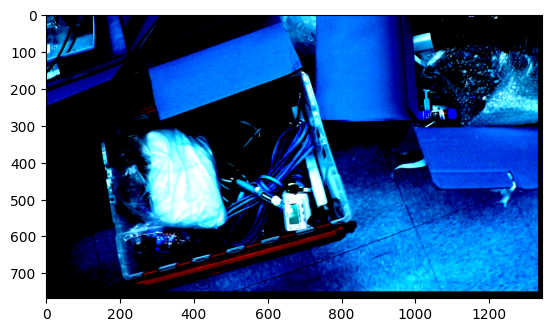

In [26]:
img = batch['img'][3].cpu().numpy()
plt.imshow(np.array([img[2, :, :], img[1, :, :], img[0, :, :]]).transpose(1,2,0))

In [86]:
len(batch['img'][0])

1

In [34]:
with torch.no_grad():
    feat = model(batch['img'])

In [35]:
feat[3].shape

torch.Size([8, 256, 25, 25])

In [29]:
len(feat)

4

In [50]:
inputs = output['input_imgs']

outputs = output['output_imgs']
recons = output['recon_img'].reshape(*outputs.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


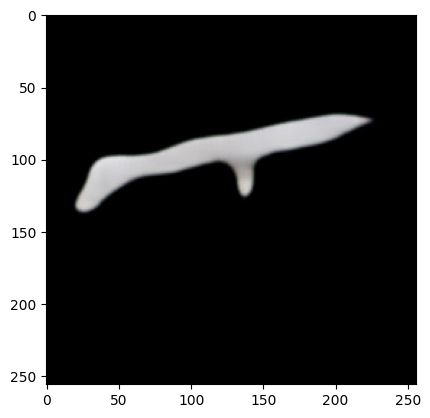

In [57]:
plt.imshow(recons[1][33].permute(1,2,0).cpu())

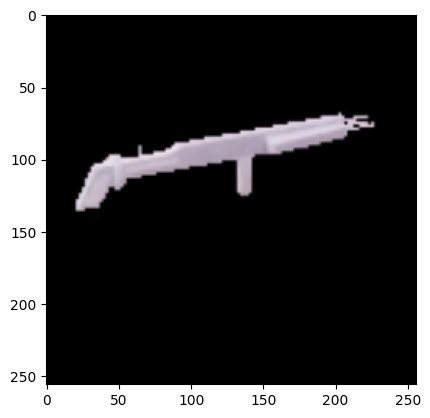

In [58]:
plt.imshow(outputs[1][33].permute(1,2,0).cpu())

In [65]:
import blobfile as bf
import io

def load_state_dict(path, **kwargs):
    """
    Load a PyTorch file without redundant fetches across MPI ranks.
    """
   
    with bf.BlobFile(path, "rb") as f:
        data = f.read()

    return torch.load(io.BytesIO(data), **kwargs)

In [66]:
a = load_state_dict(model_path)

In [70]:
for k in a.keys():
    if 'relate' in k:
        print(k)

roi_head.relate_3d.encode3d.conv3d_1.weight
roi_head.relate_3d.encode3d.conv3d_1.bias
roi_head.relate_3d.rotate.conv3d_1.weight
roi_head.relate_3d.rotate.conv3d_1.bias
roi_head.relate_3d.decoder.feat_remap.weight
roi_head.relate_3d.decoder.feat_remap.bias
roi_head.relate_3d.decoder.conv3.weight
roi_head.relate_3d.decoder.conv3.bias
roi_head.relate_3d.decoder.upconv1.weight
roi_head.relate_3d.decoder.upconv1.bias
roi_head.relate_3d.decoder.upconv2.weight
roi_head.relate_3d.decoder.upconv2.bias
roi_head.relate_3d.decoder.upconv3.weight
roi_head.relate_3d.decoder.upconv3.bias
roi_head.relate_3d.decoder.upconv4.weight
roi_head.relate_3d.decoder.upconv4.bias
roi_head.relate_3d.decoder.upconv_final.weight
roi_head.relate_3d.decoder.upconv_final.bias
roi_head.relate_3d.rotate_inv.conv3d_1.weight
roi_head.relate_3d.rotate_inv.conv3d_1.bias
roi_head.relate_3d.vox_relate.0.weight
roi_head.relate_3d.vox_relate.0.bias
roi_head.relate_3d.vox_relate.1.weight
roi_head.relate_3d.vox_relate.1.bias
roi_

In [74]:
from scripts.train_ddp_util import TrainLoop

SyntaxError: invalid syntax (train_ddp_util.py, line 107)

In [75]:
model = build_detector(cfg.get('model'))
device = torch.device('cuda:0')
model.to(device)
# print("Backbone", model.backbone.conv1.weight.device)
TrainLoop(
    model=model,
    data=dataset,
    optimizer=cfg['optimizer'],
    pretrained=cfg['resume_from'],
    batch_size=cfg.get('data')['samples_per_gpu'],
    resume_checkpoint=cfg.get('resume_checkpoint'),
    device=device,
    rank=rank,
    num_workers=cfg.get('data')['workers_per_gpu'],
    world_size=world_size
).run_loop()

load model from: torchvision://resnet50


NameError: name 'TrainLoop' is not defined

In [8]:
batch.keys()

dict_keys(['img_metas', 'img', 'gt_bboxes', 'gt_labels', 'rgb', 'mask', 'traj', 'query_pose'])

In [16]:
data_keys = list(batch.keys())

In [18]:
data_keys.remove('img_metas')

In [19]:
data_keys

['img', 'gt_bboxes', 'gt_labels', 'rgb', 'mask', 'traj', 'query_pose']

In [33]:
for k in data_keys:
    print(k)
    batch_data = batch[k].data
    try:
        batch_data = batch_data.to(device, non_blocking=True)
    except:
        try:
            batch_data = torch.stack(batch_data)
        except:
            batch_data = torch.stack([torch.stack(data) for data in batch_data])
    batch_data = batch_data.to(device, non_blocking=True)


img
gt_bboxes


RuntimeError: stack expects each tensor to be equal size, but got [8, 4] at entry 0 and [11, 4] at entry 2

In [39]:
batch['gt_bboxes'].data[0][2]

tensor([[ 48.4375, 345.3125, 178.1250, 487.5000],
        [309.3750, 310.9375, 460.9375, 490.6250],
        [425.0000,  71.8750, 603.1250, 364.0625],
        [467.1875, 303.1250, 589.0625, 365.6250],
        [248.4375, 234.3750, 428.1250, 354.6875],
        [459.3750, 360.9375, 593.7500, 500.0000],
        [132.8125, 201.5625, 285.9375, 453.1250],
        [100.0000, 517.1875, 295.3125, 748.4375],
        [387.5000, 562.5000, 576.5625, 773.4375],
        [253.1250, 462.5000, 407.8125, 645.3125],
        [375.0000, 435.9375, 620.3125, 656.2500]])

In [43]:
batch['img'].data.shape

torch.Size([1, 8, 3, 800, 800])

In [ ]:
['img', 'gt_bboxes', 'gt_labels', 'rgb', 'mask', 'traj', 'query_pose']

In [46]:
batch['img'].data[0]

tensor([[[[-0.4226, -0.3712, -0.3198,  ..., -1.4329, -1.4329, -1.4158],
          [-0.4226, -0.3883, -0.3541,  ..., -1.4500, -1.4500, -1.4500],
          [-0.4226, -0.3883, -0.3712,  ..., -1.4672, -1.4843, -1.4843],
          ...,
          [ 0.4508,  0.4337,  0.4337,  ...,  0.2282,  0.1597,  0.1083],
          [ 0.4508,  0.4508,  0.4508,  ...,  0.3138,  0.2453,  0.1939],
          [ 0.4679,  0.4508,  0.4508,  ...,  0.3652,  0.2967,  0.2453]],

         [[-0.5301, -0.4776, -0.4426,  ..., -1.5105, -1.4930, -1.4930],
          [-0.5301, -0.4951, -0.4601,  ..., -1.5280, -1.5280, -1.5280],
          [-0.5301, -0.4951, -0.4951,  ..., -1.5455, -1.5630, -1.5630],
          ...,
          [ 0.3627,  0.3452,  0.3452,  ..., -0.0049, -0.0749, -0.1275],
          [ 0.3803,  0.3627,  0.3627,  ...,  0.0826,  0.0126, -0.0399],
          [ 0.3803,  0.3803,  0.3627,  ...,  0.1352,  0.0651,  0.0126]],

         [[-0.6018, -0.5495, -0.5147,  ..., -1.4559, -1.4559, -1.4384],
          [-0.6018, -0.5670, -

In [59]:
len(batch['img_metas'].data[0])

8

In [60]:
batch['gt_bboxes'].data

[[tensor([[195.3125, 314.0625, 400.0000, 514.0625],
          [457.8125, 360.9375, 618.7500, 446.8750],
          [351.5625, 353.1250, 460.9375, 478.1250],
          [229.6875, 239.0625, 365.6250, 350.0000],
          [479.6875, 317.1875, 621.8750, 501.5625],
          [182.8125, 307.8125, 257.8125, 400.0000],
          [  0.0000, 285.9375, 170.3125, 418.7500],
          [ 28.1250, 245.3125, 168.7500, 335.9375]]),
  tensor([[300.0000, 275.0000, 428.1250, 448.4375],
          [414.0625, 290.6250, 539.0625, 350.0000],
          [410.9375, 315.6250, 550.0000, 457.8125],
          [256.2500, 323.4375, 565.6250, 637.5000],
          [440.6250, 223.4375, 668.7500, 443.7500],
          [570.3125,  50.0000, 706.2500, 368.7500],
          [306.2500, 265.6250, 457.8125, 454.6875],
          [625.0000, 156.2500, 776.5625, 342.1875]]),
  tensor([[621.8750, 345.3125, 751.5625, 487.5000],
          [339.0625, 310.9375, 490.6250, 490.6250],
          [196.8750,  71.8750, 375.0000, 364.0625],
        

In [12]:
batch

{'img_metas': [{'filename': '/home/minhnh/project_drive/CV/FewshotObjectDetection/data/OWID//P2/images/056273.jpg',
   'ori_filename': 'images/056273.jpg',
   'ori_shape': (512, 512, 3),
   'img_shape': (800, 800, 3),
   'pad_shape': (800, 800, 3),
   'scale_factor': array([1.5625, 1.5625, 1.5625, 1.5625], dtype=float32),
   'flip': False,
   'flip_direction': None,
   'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32),
    'std': array([58.395, 57.12 , 57.375], dtype=float32),
    'to_rgb': True}}],
 'img': tensor([[[[ 1.2557,  1.2214,  1.2043,  ...,  0.4337,  0.5193,  0.5878],
           [ 1.2728,  1.2728,  1.2899,  ...,  0.3138,  0.3994,  0.4679],
           [ 1.2899,  1.3242,  1.3755,  ...,  0.1254,  0.2282,  0.2967],
           ...,
           [ 0.1254,  0.2282,  0.3823,  ..., -0.0629, -0.0972, -0.1143],
           [-0.0116,  0.1254,  0.3309,  ..., -0.1486, -0.1143, -0.0972],
           [-0.0972,  0.0569,  0.2796,  ..., -0.2171, -0.1486, -0.0972]],
 
      

In [26]:
with torch.no_grad():
    output = model(**batch)

/home/minhnh/python_venv/cv/lib/python3.9/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/minhnh/python_venv/cv/lib/python3.9/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [27]:
batch

{'img_metas': [{'filename': '/home/minhnh/project_drive/CV/FewshotObjectDetection/data/OWID//P2/images/064385.jpg',
   'ori_filename': 'images/064385.jpg',
   'ori_shape': (512, 512, 3),
   'img_shape': (800, 800, 3),
   'pad_shape': (800, 800, 3),
   'scale_factor': array([1.5625, 1.5625, 1.5625, 1.5625], dtype=float32),
   'flip': True,
   'flip_direction': 'horizontal',
   'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32),
    'std': array([58.395, 57.12 , 57.375], dtype=float32),
    'to_rgb': True}}],
 'img': tensor([[[[1.4269, 1.4098, 1.4098,  ..., 1.2899, 1.2899, 1.2899],
           [1.4269, 1.4269, 1.4269,  ..., 1.3070, 1.2899, 1.2899],
           [1.4440, 1.4440, 1.4440,  ..., 1.3070, 1.2899, 1.2899],
           ...,
           [1.1358, 1.1872, 1.2385,  ..., 1.4954, 1.4954, 1.5125],
           [1.1358, 1.1700, 1.2214,  ..., 1.4954, 1.5125, 1.5297],
           [1.1529, 1.1700, 1.2043,  ..., 1.5125, 1.5297, 1.5468]],
 
          [[1.7458, 1.7283, 1.7283,

In [1]:
import os
from data.pipelines import Compose
from tqdm import tqdm
import numpy as np

In [3]:
P1_base = '/home/minhnh/project_drive/CV/FewshotObjectDetection/data/RoboTools/test_video/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
# need to coment out the Collect function
P1_pipeline = [
    dict(type='LoadP1Info', target_sz=224),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='ImagesToTensor', keys=['rgb', 'mask']),
    dict(type='Collect', keys=['rgb', 'mask']),
]

pipeline = Compose(P1_pipeline)
obj_ids = os.listdir(P1_base)

for obj_id in tqdm(obj_ids):

    tar_path = os.path.join(P1_base, '{}'.format(obj_id))
    # try:
    #     os.remove(os.path.join(tar_path, 'info.npz'))
    # except:
    #     pass
    try:
        data = np.load(os.path.join(tar_path, 'info224.npz'))
        # assert data['rgb'].shape[0] == 40
    except:
        results = dict(P1_path=P1_base, obj_id=obj_id)
        try:
            data = pipeline(results)
        except:
            print(obj_id)
            continue
        # print(os.path.join(tar_path, 'info.npz'))
        # break
        np.savez(os.path.join(tar_path, 'info224.npz'), rgb=data['rgb'], mask=data['mask'])
    # with open(os.path.join(tar_path, 'info.pkl'), 'wb') as f:
    #     pkl.dump(data, f)

 45%|████▌     | 10/22 [00:14<00:16,  1.39s/it]

sz.npz


 59%|█████▉    | 13/22 [00:16<00:10,  1.13s/it]

scene_gt_all.json


100%|██████████| 22/22 [00:27<00:00,  1.27s/it]


In [7]:
data['mask'].shape

torch.Size([40, 3, 224, 224])